In [7]:
#!pip install pydot

In [8]:
#!apt update && apt install -y graphviz

In [9]:
import sys
sys.path.insert(0, '/tf/utils/')

In [10]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import matplotlib.pyplot as plt

In [11]:
from keras.models import Model, load_model
from keras.layers import Dropout, Conv2DTranspose, ReLU, ZeroPadding2D, BatchNormalization, Input, Conv2D, Conv2DTranspose, Flatten, Dense, LeakyReLU, MaxPooling2D, UpSampling2D, Concatenate, concatenate
from keras.optimizers import Adam
import numpy as np
import tensorflow.keras.backend as K
import tensorflow as tf

from utils import calculate_snr, itakura_distortion, somar_sinais, add_white_gaussian_noise, performance
import librosa
from tqdm import tqdm

from sound import Sound

from IPython.display import Audio
import time

In [12]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [13]:
base_shape_size = 8192
ws = 255
ol = 128

In [14]:
sound_base = Sound('../../Dados/Base/', '../../Dados/ESC-50-master/audio/', base_shape_size)

Loading noise files: 100%|██████████| 2000/2000 [00:09<00:00, 203.16it/s]


In [15]:
def calculate_stft_magnitude_and_phase(signal, sampling_rate=8000, window_size=ws, overlap=ol):
    # Calcula a STFT usando a biblioteca librosa
    stft_result = librosa.stft(signal, n_fft=window_size, hop_length=overlap)
    
    magnitude, phase = librosa.magphase(stft_result)
    phi = np.angle(phase)
    f = librosa.fft_frequencies(sr=sampling_rate, n_fft=window_size)
    t = librosa.frames_to_time(np.arange(stft_result.shape[1]), sr=sampling_rate, hop_length=overlap)

    return magnitude, phi, f, t

def reconstruct_signal_from_stft(magnitude, phi, sampling_rate=8000, window_size=ws, overlap=ol):
    # Reconstruct the signal from magnitude and phase
    complex_spec = magnitude * np.exp(1j * phi)
    signal = librosa.istft(complex_spec, hop_length=overlap)

    return signal

In [16]:
class DataGenerator:
    def __init__(self, sound_files, noise_files):
        self.sound_files = sound_files
        self.noise_files = noise_files

    def generate_sample_completo(self, batch_size=32):
        while True:
            # Carrega um lote de sons
            sound_batch_choices = np.random.choice(self.sound_files.shape[0], size=batch_size, replace=False)
            sound_batch = self.sound_files[sound_batch_choices]
            
            # Carrega um lote de ruídos
            noise_batch_choices = np.random.choice(self.noise_files.shape[0], size=batch_size, replace=False)
            noise_batch = self.noise_files[noise_batch_choices]
            
            x_train = []
            y_train = []
            
            # Adiciona ruído a cada som e calcula a nota PESQ
            for sound, noise in zip(sound_batch, noise_batch):
                # noisy_sound = somar_sinais(sound, noise, sr)
                min_valor = np.min(sound)
                max_valor = np.max(sound)
                
                # Defina o novo intervalo desejado
                novo_min = -0.4
                novo_max = 0.4
                
                # Realize a escala do sinal para o novo intervalo
                sound_escalado = (sound - min_valor) / (max_valor - min_valor) * (novo_max - novo_min) + novo_min

                sr = np.random.randint(0, 20, size=(1,)[0])
                noisy_sound = somar_sinais(sound_escalado, noise, sr)
                
                # noisy_sound = add_white_gaussian_noise(noisy_sound, np.random.randint(20, 30, size=(1,)[0]))
                noisy_sound = add_white_gaussian_noise(noisy_sound, np.random.randint(20, 30, size=(1,)[0]))
                noisy_sound = np.clip(noisy_sound, -1.0, 1.0)
                
                A, phi, _, _ = calculate_stft_magnitude_and_phase(sound_escalado)
                A_noisy, phi_noisy, _, _ = calculate_stft_magnitude_and_phase(noisy_sound)

                # A /= NORM_FACTOR
                # A_noisy /= NORM_FACTOR

                # A = 10*np.log10(A)
                # A_noisy = 10*np.log10(A_noisy)

                # xA_batch.append(A)
                # xphi_batch.append(phi)
                # yA_batch.append(A_noisy)
                # yphi_batch.append(phi_noisy)
                
                # Monta o fasor normalizando a faze por Pi
                F = np.concatenate([A.reshape(A.shape[0], A.shape[1], 1), (phi.reshape(phi.shape[0], phi.shape[1], 1) / (2*np.pi)) + 0.5], axis=-1)
                F_noisy = np.concatenate([A_noisy.reshape(A_noisy.shape[0], A_noisy.shape[1], 1), (phi_noisy.reshape(phi_noisy.shape[0], phi_noisy.shape[1], 1) / (2*np.pi)) + 0.5], axis=-1)
                
                # Adiciona o exemplo ao lote de treinamento
                x_train.append(F_noisy)
                y_train.append(F)

            x_train = np.array(x_train)
            y_train = np.array(y_train)
            
            yield x_train, y_train

In [17]:
data_generator_train = DataGenerator(sound_base.train_X, sound_base.noise_sounds)
data_generator_val = DataGenerator(sound_base.val_X, sound_base.noise_sounds)

In [18]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(BatchNormalization())

    result.add(LeakyReLU())
    
    return result

In [19]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

  result.add(BatchNormalization())

  if apply_dropout:
      result.add(Dropout(0.5))

  result.add(ReLU())

  return result

In [20]:
# Tamanho da entrada
input_shape = (128, 64, 2)

# Função para criar o gerador
def Generator():
    inputs = Input(shape=input_shape)
    
    down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    # downsample(512, 4),  # (batch_size, 4, 4, 512)
    # downsample(512, 4),  # (batch_size, 2, 2, 512)
    # downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]
    
    up_stack = [
    # upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    # upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    # upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(2, 4,
                         strides=2,
                         padding='same',
                         kernel_initializer=initializer,
                         activation='linear')  # (batch_size, 256, 256, 3)
    
    x = inputs
    
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])
    
    x = last(x)
    
    return Model(inputs=inputs, outputs=x)

# Função para criar o discriminador
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = Input(shape=input_shape, name='input_image')
    tar = Input(shape=input_shape, name='target_image')
    
    x = concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)
    
    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)
    
    zero_pad1 = ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1) # (batch_size, 31, 31, 512)
    
    batchnorm1 = BatchNormalization()(conv)
    
    leaky_relu = LeakyReLU()(batchnorm1)
    
    zero_pad2 = ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)
    
    last = Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)
    
    return Model(inputs=[inp, tar], outputs=last)

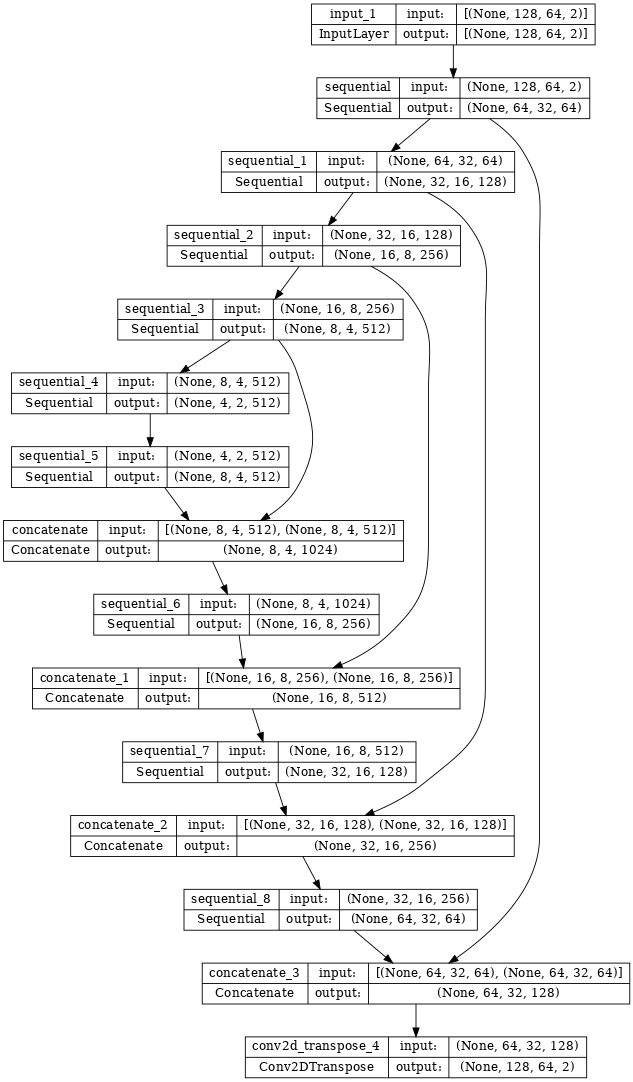

In [21]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

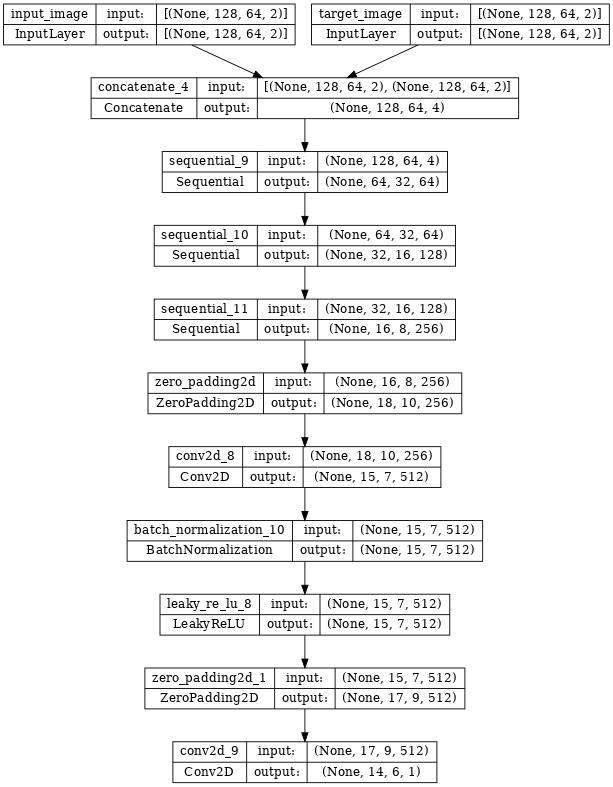

In [22]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [23]:
LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [24]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [25]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [26]:
checkpoint_dir = './p2p_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [27]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(22, 7))
    
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Log Power Spectrum - Som ruidoso', 'Log Power Spectrum - Som original', 'Log Power Spectrum - Som filtrado']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(10 * np.log10(display_list[i][..., 0]), aspect='auto', cmap='inferno')
        plt.colorbar(format='%+2.0f dB')  # Removi a variável 'im' e 'axs[0]'
        plt.axis('off')
    
    plt.show()

/tmp/ipykernel_351/1061237556.py:12: RuntimeWarning: invalid value encountered in log10
  plt.imshow(10 * np.log10(display_list[i][..., 0]), aspect='auto', cmap='inferno')


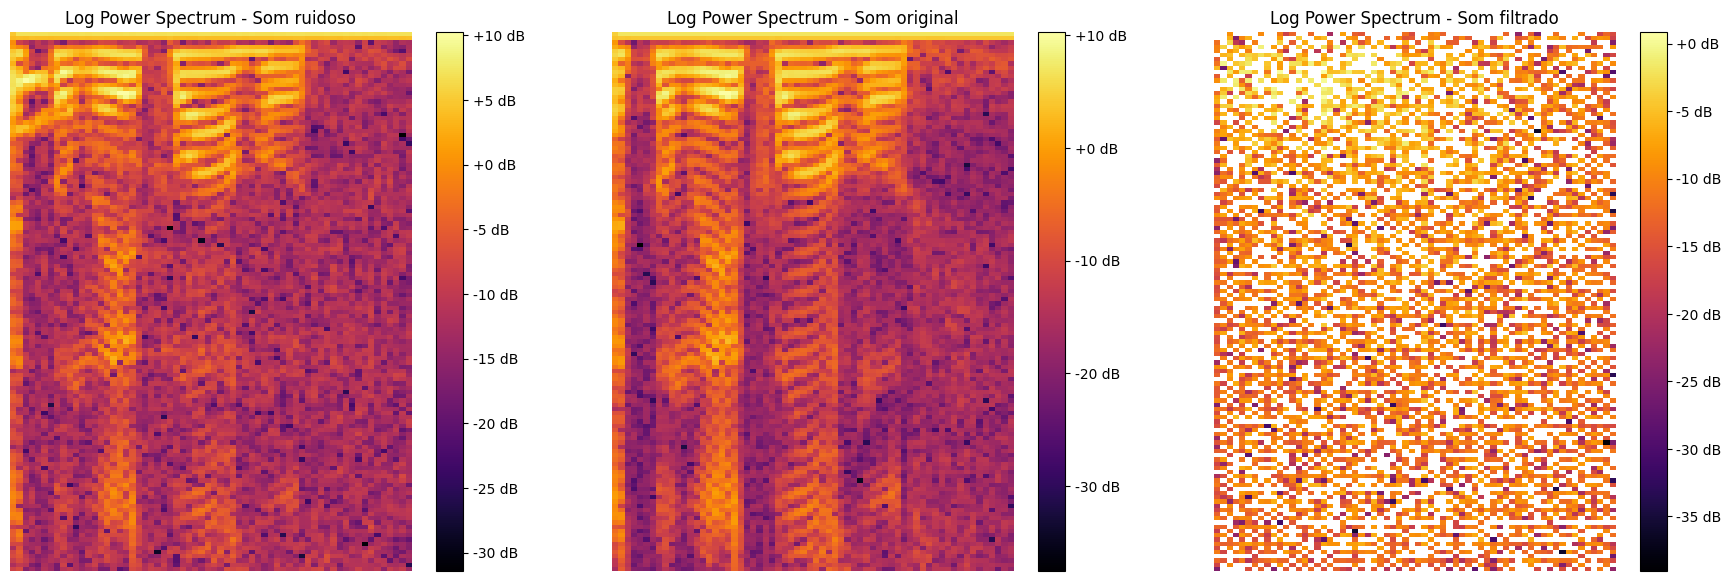

In [28]:
noisy_stft_batch, real_stft_batch = next(data_generator_train.generate_sample_completo(2))
generate_images(generator, noisy_stft_batch, real_stft_batch)

In [29]:
import datetime

In [30]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [31]:
# @tf.function
# def train_step(input_image, target, step):
#   with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#     gen_output = generator(input_image, training=True)

#     disc_real_output = discriminator([input_image, target], training=True)
#     disc_generated_output = discriminator([input_image, gen_output], training=True)

#     gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
#     disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

#   generator_gradients = gen_tape.gradient(gen_total_loss,
#                                           generator.trainable_variables)
#   discriminator_gradients = disc_tape.gradient(disc_loss,
#                                                discriminator.trainable_variables)

#   generator_optimizer.apply_gradients(zip(generator_gradients,
#                                           generator.trainable_variables))
#   discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
#                                               discriminator.trainable_variables))

#   with summary_writer.as_default():
#     tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
#     tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
#     tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
#     tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step // 1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step // 1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step // 1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step // 1000)


In [32]:
# def fit(train_ds, test_ds, steps):
#   example_input, example_target = next(iter(test_ds.take(1)))
#   start = time.time()

#   for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
#     if (step) % 1000 == 0:
#       display.clear_output(wait=True)

#       if step != 0:
#         print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

#       start = time.time()

#       generate_images(generator, example_input, example_target)
#       print(f"Step: {step//1000}k")

#     train_step(input_image, target, step)

#     # Training step
#     if (step+1) % 10 == 0:
#       print('.', end='', flush=True)


#     # Save (checkpoint) the model every 5k steps
#     if (step + 1) % 5000 == 0:
#       checkpoint.save(file_prefix=checkpoint_prefix)
def fit(data_generator, steps):
  example_input, example_target = next(data_generator)  # Get an example batch from the generator
  start = time.time()

  for step in range(steps):
    if (step + 1) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time() - start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step // 1000}k")

    input_image, target = next(data_generator)  # Get the next batch from the generator
    train_step(input_image, target, step)

    # Training step
    if (step + 1) % 10 == 0:
      print('.', end='', flush=True)

    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [33]:
%load_ext tensorboard
%tensorboard --logdir {log_dir} --host localhost --port 8088

In [ ]:
fit(data_generator_train.generate_sample_completo(batch_size=32), steps=40000)

........................................

In [11]:
# Construindo o gerador e o discriminador
# generator = build_generator(input_shape)
generator = load_model('../UNet/res-unet-STFT-90-epochs-2023-11-02_20-55-10.h5')

disc_inputs = Input(shape=input_shape)
discriminator = load_model('../UNet/res-unet-STFT-90-epochs-2023-11-02_20-55-10.h5')(disc_inputs)
discriminator = Flatten()(discriminator)
x = Dense(128, activation='tanh')(discriminator)
x = Dense(64, activation='tanh')(x)
x = Dense(1, activation='sigmoid')(x)
discriminator = Model(disc_inputs, x, name='discriminator')
# discriminator = build_discriminator(input_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam())

In [12]:
# Construindo a GAN
discriminator.trainable = False
gan_input = Input(shape=input_shape)
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(gan_input, gan_output, name='gan')
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [13]:
# Treinamento da GAN
# Aqui você pode usar seus dados de treinamento, por exemplo, X_train e Y_train, onde X_train contém as STFTs com ruído e Y_train contém as STFTs originais.
# O treinamento envolve iterar entre treinar o discriminador e treinar a GAN.
# Certifique-se de pré-processar seus dados e dividir em lotes apropriados.

# Tamanho do lote
batch_size = 128

# Número de épocas e lotes por época
num_epochs = 1
num_batches_per_epoch = len(sound_base.train_X) // batch_size

discriminator_loss = 0.

for epoch in range(num_epochs):
    pbar = tqdm(range(num_batches_per_epoch))
    for batch in pbar:
        # Restaurar o treinamento do discriminador
        discriminator.trainable = True
        generator.trainable = False

        # Treinar o discriminador com dados reais
        noisy_stft_batch, real_stft_batch = next(data_generator_train.generate_sample_completo(batch_size))
        discriminator_loss_real = discriminator.train_on_batch(real_stft_batch, np.ones((batch_size, 1)))
    
        # Gerar dados falsos e treinar o discriminador com eles
        generated_stft = generator.predict(noisy_stft_batch, verbose=False)
        discriminator_loss_fake = discriminator.train_on_batch(generated_stft, np.zeros((batch_size, 1)))
        discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)
        pbar.set_description(f'Loss fake: {discriminator_loss_fake:.5g} Loss real: {discriminator_loss_real:.5g}')

    # Imprima métricas de treinamento ao final de cada época, se desejar
    print(f'Epoch {epoch + 1}/{num_epochs}, Discriminator Loss: {discriminator_loss}')


Loss fake: 0.09937 Loss real: 0.062616: 100%|██████████| 47/47 [01:15<00:00,  1.60s/it]

Epoch 1/1, Discriminator Loss: 0.08099310472607613


In [14]:
# Treinamento da GAN
# Aqui você pode usar seus dados de treinamento, por exemplo, X_train e Y_train, onde X_train contém as STFTs com ruído e Y_train contém as STFTs originais.
# O treinamento envolve iterar entre treinar o discriminador e treinar a GAN.
# Certifique-se de pré-processar seus dados e dividir em lotes apropriados.

# Tamanho do lote
batch_size = 128

# Número de épocas e lotes por época
num_epochs = 2
num_batches_per_epoch = len(sound_base.train_X) // batch_size

gan_loss = 1.
diff_param = 10.
SAME_ITS = 4

for epoch in range(num_epochs):

    factor_dis = 1
    factor_gen = 1
    dis_loss_count = 0
    gen_loss_count = 0
    same_count = 0

    for batch in tqdm(range(num_batches_per_epoch)):
        # Restaurar o treinamento do discriminador
        discriminator.trainable = True
        generator.trainable = False

        if discriminator_loss == 0. or (gan_loss / discriminator_loss) > diff_param:
            gen_loss_count += 1
            dis_loss_count = 0
            factor_dis = 1
            factor_gen = min(2 ** gen_loss_count, 128)

        elif gan_loss == 0. or (discriminator_loss / gan_loss) > diff_param:
            dis_loss_count += 1
            gen_loss_count = 0
            factor_dis = min(2 ** dis_loss_count, 128)
            factor_gen = 1

        else:
            dis_loss_count = 0
            gen_loss_count = 0
            factor_dis = 1
            factor_gen = 1

            same_count += 1

            if same_count % SAME_ITS == 0:
                diff_param /= 2.
                same_count = 0


        print(f'Training Discriminator: {factor_dis} times\nTraining Generator: {factor_gen} times')
        
        for i in range(factor_dis):
            # Treinar o discriminador com dados reais
            noisy_stft_batch, real_stft_batch = next(data_generator_train.generate_sample_completo(batch_size))
            discriminator_loss_real = discriminator.train_on_batch(real_stft_batch, np.ones((batch_size, 1)))
        
            # Gerar dados falsos e treinar o discriminador com eles
            generated_stft = generator.predict(noisy_stft_batch, verbose=False)
            discriminator_loss_fake = discriminator.train_on_batch(generated_stft, np.zeros((batch_size, 1)))
            discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)
            print(f'Discriminator: {i + 1}/{factor_dis} - Loss fake: {discriminator_loss_fake:.5g} Loss real: {discriminator_loss_real:.5g}')

        # Definir o discriminador como não treinável
        discriminator.trainable = False
        generator.trainable = True

        for i in range(factor_gen):
            noisy_stft_batch, _ = next(data_generator_train.generate_sample_completo(batch_size))
            # Treinar a GAN com dados ruidosos (ruído) e rótulos de 1 (indicando que são dados reais)
            gan_loss = gan.train_on_batch(noisy_stft_batch, np.ones((batch_size, 1)))
            print(f'Generator: {i + 1}/{factor_gen} - Generator loss: {gan_loss}')

        print('\n\n')

    # Imprima métricas de treinamento ao final de cada época, se desejar
    print(f'Epoch {epoch + 1}/{num_epochs}, Discriminator Loss: {discriminator_loss}, GAN Loss: {gan_loss}')


  0%|          | 0/47 [00:00<?, ?it/s]

Training Discriminator: 1 times
Training Generator: 2 times
Discriminator: 1/1 - Loss fake: 0.087134 Loss real: 0.054726
Generator: 1/2 - Generator loss: 2.6534557342529297


  2%|▏         | 1/47 [00:12<09:32, 12.46s/it]

Generator: 2/2 - Generator loss: 0.9076732993125916



Training Discriminator: 1 times
Training Generator: 4 times
Discriminator: 1/1 - Loss fake: 3.095 Loss real: 0.04912
Generator: 1/4 - Generator loss: 0.0882161408662796
Generator: 2/4 - Generator loss: 0.0882161408662796
Generator: 3/4 - Generator loss: 0.0882161408662796


  4%|▍         | 2/47 [00:17<06:01,  8.04s/it]

Generator: 4/4 - Generator loss: 0.0882161408662796



Training Discriminator: 2 times
Training Generator: 1 times
Discriminator: 1/2 - Loss fake: 2.904 Loss real: 0.051705
Discriminator: 2/2 - Loss fake: 2.5118 Loss real: 0.070105


  6%|▋         | 3/47 [00:20<04:20,  5.92s/it]

Generator: 1/1 - Generator loss: 0.06080884113907814



Training Discriminator: 4 times
Training Generator: 1 times
Discriminator: 1/4 - Loss fake: 1.9795 Loss real: 0.11473
Discriminator: 2/4 - Loss fake: 1.4018 Loss real: 0.21226
Discriminator: 3/4 - Loss fake: 0.96701 Loss real: 0.38104
Discriminator: 4/4 - Loss fake: 0.10123 Loss real: 0.66444


  9%|▊         | 4/47 [00:26<04:13,  5.89s/it]

Generator: 1/1 - Generator loss: 3.7003660202026367



Training Discriminator: 1 times
Training Generator: 1 times
Discriminator: 1/1 - Loss fake: 0.029636 Loss real: 3.74


 11%|█         | 5/47 [00:28<03:10,  4.55s/it]

Generator: 1/1 - Generator loss: 3.6952905654907227



Training Discriminator: 1 times
Training Generator: 1 times
Discriminator: 1/1 - Loss fake: 0.054981 Loss real: 3.3021


 13%|█▎        | 6/47 [00:30<02:33,  3.74s/it]

Generator: 1/1 - Generator loss: 3.4509530067443848



Training Discriminator: 1 times
Training Generator: 1 times
Discriminator: 1/1 - Loss fake: 0.083346 Loss real: 2.8434


 15%|█▍        | 7/47 [00:33<02:09,  3.25s/it]

Generator: 1/1 - Generator loss: 2.9460301399230957



Training Discriminator: 1 times
Training Generator: 1 times
Discriminator: 1/1 - Loss fake: 0.18819 Loss real: 2.2172


 17%|█▋        | 8/47 [00:35<01:53,  2.91s/it]

Generator: 1/1 - Generator loss: 2.568941116333008



Training Discriminator: 1 times
Training Generator: 1 times
Discriminator: 1/1 - Loss fake: 0.28751 Loss real: 1.5899


 19%|█▉        | 9/47 [00:37<01:41,  2.67s/it]

Generator: 1/1 - Generator loss: 2.2134175300598145



Training Discriminator: 1 times
Training Generator: 1 times
Discriminator: 1/1 - Loss fake: 0.46316 Loss real: 1.1957


 21%|██▏       | 10/47 [00:39<01:33,  2.52s/it]

Generator: 1/1 - Generator loss: 1.8580234050750732



Training Discriminator: 1 times
Training Generator: 1 times
Discriminator: 1/1 - Loss fake: 0.61909 Loss real: 0.88844


 23%|██▎       | 11/47 [00:41<01:26,  2.41s/it]

Generator: 1/1 - Generator loss: 1.615861177444458



Training Discriminator: 1 times
Training Generator: 1 times
Discriminator: 1/1 - Loss fake: 0.75418 Loss real: 0.69702


 26%|██▌       | 12/47 [00:44<01:21,  2.33s/it]

Generator: 1/1 - Generator loss: 1.4360804557800293



Training Discriminator: 1 times
Training Generator: 1 times
Discriminator: 1/1 - Loss fake: 0.8955 Loss real: 0.57434


 28%|██▊       | 13/47 [00:46<01:17,  2.28s/it]

Generator: 1/1 - Generator loss: 1.2094053030014038



Training Discriminator: 1 times
Training Generator: 1 times
Discriminator: 1/1 - Loss fake: 1.078 Loss real: 0.4583


 30%|██▉       | 14/47 [00:48<01:13,  2.24s/it]

Generator: 1/1 - Generator loss: 1.129509687423706



Training Discriminator: 1 times
Training Generator: 1 times
Discriminator: 1/1 - Loss fake: 1.1035 Loss real: 0.40808


 32%|███▏      | 15/47 [00:50<01:10,  2.22s/it]

Generator: 1/1 - Generator loss: 1.0585561990737915



Training Discriminator: 1 times
Training Generator: 1 times
Discriminator: 1/1 - Loss fake: 1.0829 Loss real: 0.40881


 34%|███▍      | 16/47 [00:52<01:08,  2.20s/it]

Generator: 1/1 - Generator loss: 1.0617884397506714



Training Discriminator: 1 times
Training Generator: 2 times
Discriminator: 1/1 - Loss fake: 1.0775 Loss real: 0.42174
Generator: 1/2 - Generator loss: 1.0393623113632202


 36%|███▌      | 17/47 [00:55<01:13,  2.46s/it]

Generator: 2/2 - Generator loss: 1.0393623113632202



Training Discriminator: 1 times
Training Generator: 4 times
Discriminator: 1/1 - Loss fake: 0.97286 Loss real: 0.45702
Generator: 1/4 - Generator loss: 1.0804274082183838
Generator: 2/4 - Generator loss: 1.0804274082183838
Generator: 3/4 - Generator loss: 1.0804274082183838


 38%|███▊      | 18/47 [01:00<01:32,  3.21s/it]

Generator: 4/4 - Generator loss: 1.0804274082183838



Training Discriminator: 1 times
Training Generator: 8 times
Discriminator: 1/1 - Loss fake: 0.88772 Loss real: 0.5085
Generator: 1/8 - Generator loss: 1.128558874130249
Generator: 2/8 - Generator loss: 1.128558874130249
Generator: 3/8 - Generator loss: 1.128558874130249
Generator: 4/8 - Generator loss: 1.128558874130249
Generator: 5/8 - Generator loss: 1.128558874130249
Generator: 6/8 - Generator loss: 1.128558874130249
Generator: 7/8 - Generator loss: 1.128558874130249


 40%|████      | 19/47 [01:09<02:15,  4.84s/it]

Generator: 8/8 - Generator loss: 1.128558874130249



Training Discriminator: 1 times
Training Generator: 16 times
Discriminator: 1/1 - Loss fake: 0.81663 Loss real: 0.57016
Generator: 1/16 - Generator loss: 1.1781713962554932
Generator: 2/16 - Generator loss: 1.1781713962554932
Generator: 3/16 - Generator loss: 1.1781713962554932
Generator: 4/16 - Generator loss: 1.1781713962554932
Generator: 5/16 - Generator loss: 1.1781713962554932
Generator: 6/16 - Generator loss: 1.1781713962554932
Generator: 7/16 - Generator loss: 1.1781713962554932
Generator: 8/16 - Generator loss: 1.1781713962554932
Generator: 9/16 - Generator loss: 1.1781713962554932
Generator: 10/16 - Generator loss: 1.1781713962554932
Generator: 11/16 - Generator loss: 1.1781713962554932
Generator: 12/16 - Generator loss: 1.1781713962554932
Generator: 13/16 - Generator loss: 1.1781713962554932
Generator: 14/16 - Generator loss: 1.1781713962554932
Generator: 15/16 - Generator loss: 1.1781713962554932


 43%|████▎     | 20/47 [01:25<03:41,  8.21s/it]

Generator: 16/16 - Generator loss: 1.1781713962554932



Training Discriminator: 1 times
Training Generator: 32 times
Discriminator: 1/1 - Loss fake: 0.75464 Loss real: 0.61682
Generator: 1/32 - Generator loss: 1.2128612995147705
Generator: 2/32 - Generator loss: 1.2128612995147705
Generator: 3/32 - Generator loss: 1.2128612995147705
Generator: 4/32 - Generator loss: 1.2128612995147705
Generator: 5/32 - Generator loss: 1.2128612995147705
Generator: 6/32 - Generator loss: 1.2128612995147705
Generator: 7/32 - Generator loss: 1.2128612995147705
Generator: 8/32 - Generator loss: 1.2128612995147705
Generator: 9/32 - Generator loss: 1.2128612995147705
Generator: 10/32 - Generator loss: 1.2128612995147705
Generator: 11/32 - Generator loss: 1.2128612995147705
Generator: 12/32 - Generator loss: 1.2128612995147705
Generator: 13/32 - Generator loss: 1.2128612995147705
Generator: 14/32 - Generator loss: 1.2128612995147705
Generator: 15/32 - Generator loss: 1.2128612995147705
Generator: 16/32 - Gen

 45%|████▍     | 21/47 [01:56<06:30, 15.00s/it]

Generator: 32/32 - Generator loss: 1.2128612995147705



Training Discriminator: 1 times
Training Generator: 64 times
Discriminator: 1/1 - Loss fake: 0.74918 Loss real: 0.64981
Generator: 1/64 - Generator loss: 1.2402186393737793
Generator: 2/64 - Generator loss: 1.2402186393737793
Generator: 3/64 - Generator loss: 1.2402186393737793
Generator: 4/64 - Generator loss: 1.2402186393737793
Generator: 5/64 - Generator loss: 1.2402186393737793
Generator: 6/64 - Generator loss: 1.2402186393737793
Generator: 7/64 - Generator loss: 1.2402186393737793
Generator: 8/64 - Generator loss: 1.2402186393737793
Generator: 9/64 - Generator loss: 1.2402186393737793
Generator: 10/64 - Generator loss: 1.2402186393737793
Generator: 11/64 - Generator loss: 1.2402186393737793
Generator: 12/64 - Generator loss: 1.2402186393737793
Generator: 13/64 - Generator loss: 1.2402186393737793
Generator: 14/64 - Generator loss: 1.2402186393737793
Generator: 15/64 - Generator loss: 1.2402186393737793
Generator: 16/64 - Gen

 47%|████▋     | 22/47 [02:56<11:56, 28.67s/it]

Generator: 64/64 - Generator loss: 1.2402186393737793



Training Discriminator: 1 times
Training Generator: 128 times
Discriminator: 1/1 - Loss fake: 0.7023 Loss real: 0.67755
Generator: 1/128 - Generator loss: 1.274157166481018
Generator: 2/128 - Generator loss: 1.274157166481018
Generator: 3/128 - Generator loss: 1.274157166481018
Generator: 4/128 - Generator loss: 1.274157166481018
Generator: 5/128 - Generator loss: 1.274157166481018
Generator: 6/128 - Generator loss: 1.274157166481018
Generator: 7/128 - Generator loss: 1.274157166481018
Generator: 8/128 - Generator loss: 1.274157166481018
Generator: 9/128 - Generator loss: 1.274157166481018
Generator: 10/128 - Generator loss: 1.274157166481018
Generator: 11/128 - Generator loss: 1.274157166481018
Generator: 12/128 - Generator loss: 1.274157166481018
Generator: 13/128 - Generator loss: 1.274157166481018
Generator: 14/128 - Generator loss: 1.274157166481018
Generator: 15/128 - Generator loss: 1.274157166481018
Generator: 16/128 - Ge

 49%|████▉     | 23/47 [04:56<22:22, 55.92s/it]

Generator: 128/128 - Generator loss: 1.274157166481018



Training Discriminator: 1 times
Training Generator: 128 times
Discriminator: 1/1 - Loss fake: 0.73089 Loss real: 0.68986
Generator: 1/128 - Generator loss: 1.3031048774719238
Generator: 2/128 - Generator loss: 1.3031048774719238
Generator: 3/128 - Generator loss: 1.3031048774719238
Generator: 4/128 - Generator loss: 1.3031048774719238
Generator: 5/128 - Generator loss: 1.3031048774719238
Generator: 6/128 - Generator loss: 1.3031048774719238
Generator: 7/128 - Generator loss: 1.3031048774719238
Generator: 8/128 - Generator loss: 1.3031048774719238
Generator: 9/128 - Generator loss: 1.3031048774719238
Generator: 10/128 - Generator loss: 1.3031048774719238
Generator: 11/128 - Generator loss: 1.3031048774719238
Generator: 12/128 - Generator loss: 1.3031048774719238
Generator: 13/128 - Generator loss: 1.3031048774719238
Generator: 14/128 - Generator loss: 1.3031048774719238
Generator: 15/128 - Generator loss: 1.3031048774719238
Gener

 51%|█████     | 24/47 [06:55<28:45, 75.00s/it]

Generator: 128/128 - Generator loss: 1.3031048774719238



Training Discriminator: 1 times
Training Generator: 128 times
Discriminator: 1/1 - Loss fake: 0.69963 Loss real: 0.6742
Generator: 1/128 - Generator loss: 1.3280987739562988
Generator: 2/128 - Generator loss: 1.3280987739562988
Generator: 3/128 - Generator loss: 1.3280987739562988
Generator: 4/128 - Generator loss: 1.3280987739562988
Generator: 5/128 - Generator loss: 1.3280987739562988
Generator: 6/128 - Generator loss: 1.3280987739562988
Generator: 7/128 - Generator loss: 1.3280987739562988
Generator: 8/128 - Generator loss: 1.3280987739562988
Generator: 9/128 - Generator loss: 1.3280987739562988
Generator: 10/128 - Generator loss: 1.3280987739562988
Generator: 11/128 - Generator loss: 1.3280987739562988
Generator: 12/128 - Generator loss: 1.3280987739562988
Generator: 13/128 - Generator loss: 1.3280987739562988
Generator: 14/128 - Generator loss: 1.3280987739562988
Generator: 15/128 - Generator loss: 1.3280987739562988
Gener

 53%|█████▎    | 25/47 [08:54<32:20, 88.19s/it]

Generator: 128/128 - Generator loss: 1.3280987739562988



Training Discriminator: 1 times
Training Generator: 128 times
Discriminator: 1/1 - Loss fake: 0.75824 Loss real: 0.68363
Generator: 1/128 - Generator loss: 1.3502109050750732
Generator: 2/128 - Generator loss: 1.3502109050750732
Generator: 3/128 - Generator loss: 1.3502109050750732
Generator: 4/128 - Generator loss: 1.3502109050750732
Generator: 5/128 - Generator loss: 1.3502109050750732
Generator: 6/128 - Generator loss: 1.3502109050750732
Generator: 7/128 - Generator loss: 1.3502109050750732
Generator: 8/128 - Generator loss: 1.3502109050750732
Generator: 9/128 - Generator loss: 1.3502109050750732
Generator: 10/128 - Generator loss: 1.3502109050750732
Generator: 11/128 - Generator loss: 1.3502109050750732
Generator: 12/128 - Generator loss: 1.3502109050750732
Generator: 13/128 - Generator loss: 1.3502109050750732
Generator: 14/128 - Generator loss: 1.3502109050750732
Generator: 15/128 - Generator loss: 1.3502109050750732
Gene

 55%|█████▌    | 26/47 [10:53<34:06, 97.45s/it]

Generator: 128/128 - Generator loss: 1.3502109050750732



Training Discriminator: 1 times
Training Generator: 128 times
Discriminator: 1/1 - Loss fake: 0.77313 Loss real: 0.63271
Generator: 1/128 - Generator loss: 1.3385590314865112
Generator: 2/128 - Generator loss: 1.3385590314865112
Generator: 3/128 - Generator loss: 1.3385590314865112
Generator: 4/128 - Generator loss: 1.3385590314865112
Generator: 5/128 - Generator loss: 1.3385590314865112
Generator: 6/128 - Generator loss: 1.3385590314865112
Generator: 7/128 - Generator loss: 1.3385590314865112
Generator: 8/128 - Generator loss: 1.3385590314865112
Generator: 9/128 - Generator loss: 1.3385590314865112
Generator: 10/128 - Generator loss: 1.3385590314865112
Generator: 11/128 - Generator loss: 1.3385590314865112
Generator: 12/128 - Generator loss: 1.3385590314865112
Generator: 13/128 - Generator loss: 1.3385590314865112
Generator: 14/128 - Generator loss: 1.3385590314865112
Generator: 15/128 - Generator loss: 1.3385590314865112
Gene

 57%|█████▋    | 27/47 [12:53<34:40, 104.04s/it]

Generator: 128/128 - Generator loss: 1.3385590314865112



Training Discriminator: 1 times
Training Generator: 128 times
Discriminator: 1/1 - Loss fake: 0.74383 Loss real: 0.64592
Generator: 1/128 - Generator loss: 1.3334417343139648
Generator: 2/128 - Generator loss: 1.3334417343139648
Generator: 3/128 - Generator loss: 1.3334417343139648
Generator: 4/128 - Generator loss: 1.3334417343139648
Generator: 5/128 - Generator loss: 1.3334417343139648
Generator: 6/128 - Generator loss: 1.3334417343139648
Generator: 7/128 - Generator loss: 1.3334417343139648
Generator: 8/128 - Generator loss: 1.3334417343139648
Generator: 9/128 - Generator loss: 1.3334417343139648
Generator: 10/128 - Generator loss: 1.3334417343139648
Generator: 11/128 - Generator loss: 1.3334417343139648
Generator: 12/128 - Generator loss: 1.3334417343139648
Generator: 13/128 - Generator loss: 1.3334417343139648
Generator: 14/128 - Generator loss: 1.3334417343139648
Generator: 15/128 - Generator loss: 1.3334417343139648
Gene

 60%|█████▉    | 28/47 [14:52<34:26, 108.74s/it]

Generator: 128/128 - Generator loss: 1.3334417343139648



Training Discriminator: 1 times
Training Generator: 128 times
Discriminator: 1/1 - Loss fake: 0.71607 Loss real: 0.66876
Generator: 1/128 - Generator loss: 1.354240894317627
Generator: 2/128 - Generator loss: 1.354240894317627
Generator: 3/128 - Generator loss: 1.354240894317627
Generator: 4/128 - Generator loss: 1.354240894317627
Generator: 5/128 - Generator loss: 1.354240894317627
Generator: 6/128 - Generator loss: 1.354240894317627
Generator: 7/128 - Generator loss: 1.354240894317627
Generator: 8/128 - Generator loss: 1.354240894317627
Generator: 9/128 - Generator loss: 1.354240894317627
Generator: 10/128 - Generator loss: 1.354240894317627
Generator: 11/128 - Generator loss: 1.354240894317627
Generator: 12/128 - Generator loss: 1.354240894317627
Generator: 13/128 - Generator loss: 1.354240894317627
Generator: 14/128 - Generator loss: 1.354240894317627
Generator: 15/128 - Generator loss: 1.354240894317627
Generator: 16/128 -

 62%|██████▏   | 29/47 [16:52<33:33, 111.84s/it]

Generator: 128/128 - Generator loss: 1.354240894317627



Training Discriminator: 1 times
Training Generator: 128 times
Discriminator: 1/1 - Loss fake: 0.69219 Loss real: 0.68931
Generator: 1/128 - Generator loss: 1.371832251548767
Generator: 2/128 - Generator loss: 1.371832251548767
Generator: 3/128 - Generator loss: 1.371832251548767
Generator: 4/128 - Generator loss: 1.371832251548767
Generator: 5/128 - Generator loss: 1.371832251548767
Generator: 6/128 - Generator loss: 1.371832251548767
Generator: 7/128 - Generator loss: 1.371832251548767
Generator: 8/128 - Generator loss: 1.371832251548767
Generator: 9/128 - Generator loss: 1.371832251548767
Generator: 10/128 - Generator loss: 1.371832251548767
Generator: 11/128 - Generator loss: 1.371832251548767
Generator: 12/128 - Generator loss: 1.371832251548767
Generator: 13/128 - Generator loss: 1.371832251548767
Generator: 14/128 - Generator loss: 1.371832251548767
Generator: 15/128 - Generator loss: 1.371832251548767
Generator: 16/128 - 

 64%|██████▍   | 30/47 [18:50<32:16, 113.91s/it]

Generator: 128/128 - Generator loss: 1.371832251548767



Training Discriminator: 1 times
Training Generator: 128 times
Discriminator: 1/1 - Loss fake: 0.69958 Loss real: 0.70177
Generator: 1/128 - Generator loss: 1.3859833478927612
Generator: 2/128 - Generator loss: 1.3859833478927612
Generator: 3/128 - Generator loss: 1.3859833478927612
Generator: 4/128 - Generator loss: 1.3859833478927612
Generator: 5/128 - Generator loss: 1.3859833478927612
Generator: 6/128 - Generator loss: 1.3859833478927612
Generator: 7/128 - Generator loss: 1.3859833478927612
Generator: 8/128 - Generator loss: 1.3859833478927612
Generator: 9/128 - Generator loss: 1.3859833478927612
Generator: 10/128 - Generator loss: 1.3859833478927612
Generator: 11/128 - Generator loss: 1.3859833478927612
Generator: 12/128 - Generator loss: 1.3859833478927612
Generator: 13/128 - Generator loss: 1.3859833478927612
Generator: 14/128 - Generator loss: 1.3859833478927612
Generator: 15/128 - Generator loss: 1.3859833478927612
Gener

 66%|██████▌   | 31/47 [20:50<30:52, 115.81s/it]

Generator: 128/128 - Generator loss: 1.3859833478927612



Training Discriminator: 1 times
Training Generator: 128 times
Discriminator: 1/1 - Loss fake: 0.68429 Loss real: 0.70835
Generator: 1/128 - Generator loss: 1.3133950233459473
Generator: 2/128 - Generator loss: 1.3133950233459473
Generator: 3/128 - Generator loss: 1.3133950233459473
Generator: 4/128 - Generator loss: 1.3133950233459473
Generator: 5/128 - Generator loss: 1.3133950233459473
Generator: 6/128 - Generator loss: 1.3133950233459473
Generator: 7/128 - Generator loss: 1.3133950233459473
Generator: 8/128 - Generator loss: 1.3133950233459473
Generator: 9/128 - Generator loss: 1.3133950233459473
Generator: 10/128 - Generator loss: 1.3133950233459473
Generator: 11/128 - Generator loss: 1.3133950233459473
Generator: 12/128 - Generator loss: 1.3133950233459473
Generator: 13/128 - Generator loss: 1.3133950233459473
Generator: 14/128 - Generator loss: 1.3133950233459473
Generator: 15/128 - Generator loss: 1.3133950233459473
Gene

 68%|██████▊   | 32/47 [22:50<29:15, 117.01s/it]

Generator: 128/128 - Generator loss: 1.3133950233459473



Training Discriminator: 1 times
Training Generator: 128 times
Discriminator: 1/1 - Loss fake: 0.70165 Loss real: 0.71134
Generator: 1/128 - Generator loss: 1.3219571113586426
Generator: 2/128 - Generator loss: 1.3219571113586426
Generator: 3/128 - Generator loss: 1.3219571113586426
Generator: 4/128 - Generator loss: 1.3219571113586426
Generator: 5/128 - Generator loss: 1.3219571113586426
Generator: 6/128 - Generator loss: 1.3219571113586426
Generator: 7/128 - Generator loss: 1.3219571113586426
Generator: 8/128 - Generator loss: 1.3219571113586426
Generator: 9/128 - Generator loss: 1.3219571113586426
Generator: 10/128 - Generator loss: 1.3219571113586426
Generator: 11/128 - Generator loss: 1.3219571113586426
Generator: 12/128 - Generator loss: 1.3219571113586426
Generator: 13/128 - Generator loss: 1.3219571113586426
Generator: 14/128 - Generator loss: 1.3219571113586426
Generator: 15/128 - Generator loss: 1.3219571113586426
Gene

 70%|███████   | 33/47 [24:49<27:24, 117.45s/it]

Generator: 128/128 - Generator loss: 1.3219571113586426



Training Discriminator: 1 times
Training Generator: 128 times
Discriminator: 1/1 - Loss fake: 0.69352 Loss real: 0.70356
Generator: 1/128 - Generator loss: 1.4312294721603394
Generator: 2/128 - Generator loss: 1.4312294721603394
Generator: 3/128 - Generator loss: 1.4312294721603394
Generator: 4/128 - Generator loss: 1.4312294721603394
Generator: 5/128 - Generator loss: 1.4312294721603394
Generator: 6/128 - Generator loss: 1.4312294721603394
Generator: 7/128 - Generator loss: 1.4312294721603394
Generator: 8/128 - Generator loss: 1.4312294721603394
Generator: 9/128 - Generator loss: 1.4312294721603394
Generator: 10/128 - Generator loss: 1.4312294721603394
Generator: 11/128 - Generator loss: 1.4312294721603394
Generator: 12/128 - Generator loss: 1.4312294721603394
Generator: 13/128 - Generator loss: 1.4312294721603394
Generator: 14/128 - Generator loss: 1.4312294721603394
Generator: 15/128 - Generator loss: 1.4312294721603394
Gene

 72%|███████▏  | 34/47 [26:47<25:29, 117.63s/it]

Generator: 128/128 - Generator loss: 1.4312294721603394



Training Discriminator: 1 times
Training Generator: 128 times
Discriminator: 1/1 - Loss fake: 0.68758 Loss real: 0.70882
Generator: 1/128 - Generator loss: 1.4355186223983765
Generator: 2/128 - Generator loss: 1.4355186223983765
Generator: 3/128 - Generator loss: 1.4355186223983765
Generator: 4/128 - Generator loss: 1.4355186223983765
Generator: 5/128 - Generator loss: 1.4355186223983765
Generator: 6/128 - Generator loss: 1.4355186223983765
Generator: 7/128 - Generator loss: 1.4355186223983765
Generator: 8/128 - Generator loss: 1.4355186223983765
Generator: 9/128 - Generator loss: 1.4355186223983765
Generator: 10/128 - Generator loss: 1.4355186223983765
Generator: 11/128 - Generator loss: 1.4355186223983765
Generator: 12/128 - Generator loss: 1.4355186223983765
Generator: 13/128 - Generator loss: 1.4355186223983765
Generator: 14/128 - Generator loss: 1.4355186223983765
Generator: 15/128 - Generator loss: 1.4355186223983765
Gene

 74%|███████▍  | 35/47 [28:45<23:34, 117.84s/it]

Generator: 128/128 - Generator loss: 1.4355186223983765



Training Discriminator: 1 times
Training Generator: 128 times
Discriminator: 1/1 - Loss fake: 0.68369 Loss real: 0.70727
Generator: 1/128 - Generator loss: 1.4383498430252075
Generator: 2/128 - Generator loss: 1.4383498430252075
Generator: 3/128 - Generator loss: 1.4383498430252075
Generator: 4/128 - Generator loss: 1.4383498430252075
Generator: 5/128 - Generator loss: 1.4383498430252075
Generator: 6/128 - Generator loss: 1.4383498430252075
Generator: 7/128 - Generator loss: 1.4383498430252075
Generator: 8/128 - Generator loss: 1.4383498430252075
Generator: 9/128 - Generator loss: 1.4383498430252075
Generator: 10/128 - Generator loss: 1.4383498430252075
Generator: 11/128 - Generator loss: 1.4383498430252075
Generator: 12/128 - Generator loss: 1.4383498430252075
Generator: 13/128 - Generator loss: 1.4383498430252075
Generator: 14/128 - Generator loss: 1.4383498430252075
Generator: 15/128 - Generator loss: 1.4383498430252075
Gene

 77%|███████▋  | 36/47 [30:44<21:38, 118.07s/it]

Generator: 128/128 - Generator loss: 1.4383498430252075



Training Discriminator: 1 times
Training Generator: 128 times
Discriminator: 1/1 - Loss fake: 0.68282 Loss real: 0.69872
Generator: 1/128 - Generator loss: 1.440241813659668
Generator: 2/128 - Generator loss: 1.440241813659668
Generator: 3/128 - Generator loss: 1.440241813659668
Generator: 4/128 - Generator loss: 1.440241813659668
Generator: 5/128 - Generator loss: 1.440241813659668
Generator: 6/128 - Generator loss: 1.440241813659668
Generator: 7/128 - Generator loss: 1.440241813659668
Generator: 8/128 - Generator loss: 1.440241813659668
Generator: 9/128 - Generator loss: 1.440241813659668
Generator: 10/128 - Generator loss: 1.440241813659668
Generator: 11/128 - Generator loss: 1.440241813659668
Generator: 12/128 - Generator loss: 1.440241813659668
Generator: 13/128 - Generator loss: 1.440241813659668
Generator: 14/128 - Generator loss: 1.440241813659668
Generator: 15/128 - Generator loss: 1.440241813659668
Generator: 16/128 -

 77%|███████▋  | 36/47 [31:55<09:45, 53.22s/it] 


KeyboardInterrupt: 

In [ ]:
from datetime import datetime
# Get the current datetime
current_datetime = datetime.now()

# Format the datetime as a string to use in the file name
datetime_str = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

gan.save('gan-2xSTFT-2-epochs-'+datetime_str+'.h5')

In [15]:
x_test, y_test = next(data_generator_val.generate_sample_completo(batch_size=1))

In [16]:
F_f = generator.predict(x_test)

1/1 [==============================] - 0s 223ms/step


In [17]:
A = y_test.reshape(y_test.shape[1], y_test.shape[2], y_test.shape[3])[:, :, 0]
phi = (y_test.reshape(y_test.shape[1], y_test.shape[2], y_test.shape[3])[:, :, 1] - 0.5) * 2 * np.pi

A_f = F_f.reshape(F_f.shape[1], F_f.shape[2], F_f.shape[3])[:, :, 0]
phi_f = (F_f.reshape(F_f.shape[1], F_f.shape[2], F_f.shape[3])[:, :, 1] - 0.5) * 2 * np.pi

A_n = x_test.reshape(x_test.shape[1], x_test.shape[2], x_test.shape[3])[:, :, 0]
phi_n = (x_test.reshape(x_test.shape[1], x_test.shape[2], x_test.shape[3])[:, :, 1] - 0.5) * 2 * np.pi

/tmp/ipykernel_22182/3224369657.py:18: RuntimeWarning: divide by zero encountered in log10
  im = axs[2].imshow(10*np.log10(A_f), aspect='auto', cmap='inferno')


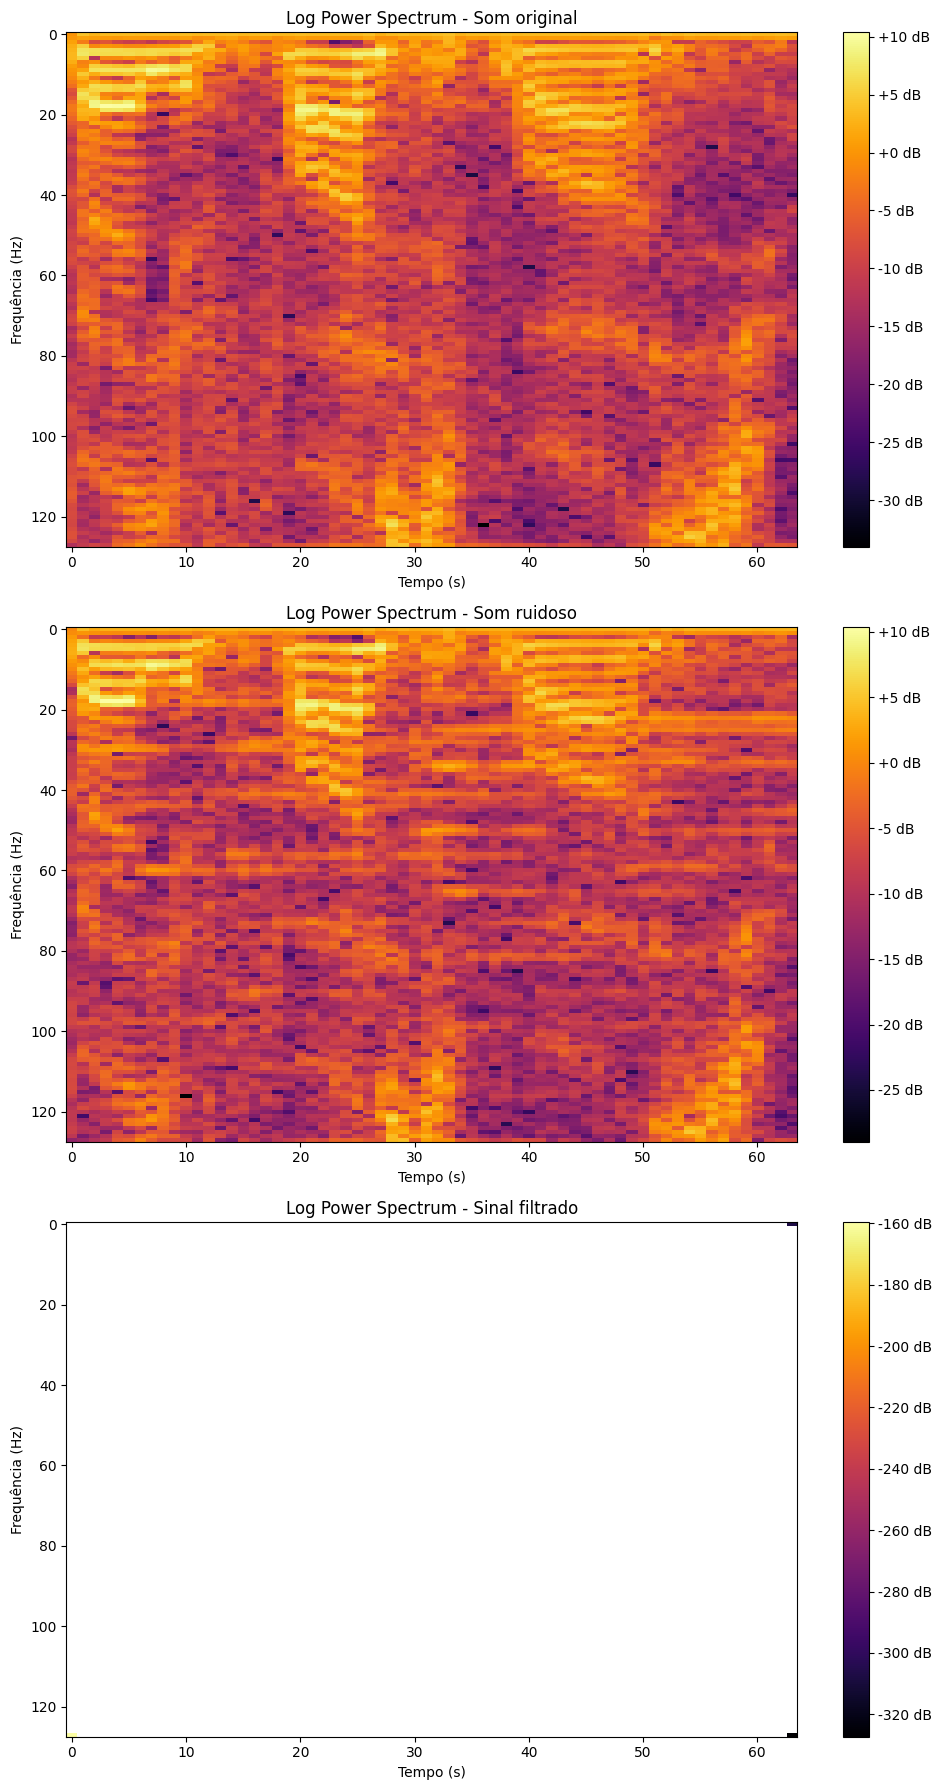

In [18]:
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Primeiro gráfico
im = axs[0].imshow(10*np.log10(A), aspect='auto', cmap='inferno')
axs[0].set_title('Log Power Spectrum - Som original')
axs[0].set_xlabel('Tempo (s)')
axs[0].set_ylabel('Frequência (Hz)')
fig.colorbar(im, ax=axs[0], format='%+2.0f dB')

# Segundo gráfico
im = axs[1].imshow(10*np.log10(A_n), aspect='auto', cmap='inferno')
axs[1].set_title('Log Power Spectrum - Som ruidoso')
axs[1].set_xlabel('Tempo (s)')
axs[1].set_ylabel('Frequência (Hz)')
fig.colorbar(im, ax=axs[1], format='%+2.0f dB')

# Terceiro gráfico
im = axs[2].imshow(10*np.log10(A_f), aspect='auto', cmap='inferno')
axs[2].set_title('Log Power Spectrum - Sinal filtrado')
axs[2].set_xlabel('Tempo (s)')
axs[2].set_ylabel('Frequência (Hz)')
fig.colorbar(im, ax=axs[2], format='%+2.0f dB')

plt.tight_layout()  # Para evitar sobreposição de rótulos e gráficos
plt.show()

In [19]:
status = gan.predict(x_test)

1/1 [==============================] - 1s 1s/step


In [20]:
status

array([[0.23687041]], dtype=float32)

In [ ]:
s = reconstruct_signal_from_stft(A, phi)
s_n = reconstruct_signal_from_stft(A_n, phi_n)
s_f = reconstruct_signal_from_stft(A_f, phi_f)

In [ ]:
# Criando figuras e eixos separados para cada array
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

# Plotando o primeiro array
ax1.plot(s)
ax1.set_ylabel('Sinal de voz ruidoso')

# Plotando o primeiro array
ax2.plot(s_n)
ax2.set_ylabel('Sinal de voz ruidoso')

ax3.plot(s_f)
ax3.set_ylabel('Sinal de voz filtrado')

# Exibindo os gráficos
plt.show()

In [ ]:
Audio(data=s, rate=8000)

In [ ]:
Audio(data=s_n, rate=8000)

In [ ]:
Audio(data=s_f, rate=8000)